In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline
import IPython.display
import librosa
import librosa.display

In [2]:
num_classes = 10
np.random.seed(133)
data_folder = "E:\\Applications\\Github\\GitHub\\Machine-Learning-Engineer\\p5 - Song Genre Classification\\data\\"
train_filename = data_folder+"genres.tar.gz"

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0] 
    if os.path.isdir(root) and not force:
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    data_folders = [os.path.join(root, d) for d in sorted(os.listdir(root))if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception('Expected %d folders, one per class. Found %d instead.' % (
            num_classes, len(data_folders)))
    #print(data_folders)
    
    return data_folders
  
train_folders = maybe_extract(train_filename)
train_filename = train_filename.replace(".tar.gz","\\")
#test_folders = maybe_extract(test_filename)

E:\Applications\Github\GitHub\Machine-Learning-Engineer\p5 - Song Genre Classification\data\genres already present - Skipping extraction of E:\Applications\Github\GitHub\Machine-Learning-Engineer\p5 - Song Genre Classification\data\genres.tar.gz.


In [3]:
import glob
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += (window_size / 2)

def extract_features(parent_dir,sub_dirs,file_ext="*.au",bands = 60, frames = 41):
    window_size = 512 * (frames - 1)
    log_specgrams = []
    labels = []
    for l, sub_dir in enumerate(sub_dirs):
        print(sub_dir)
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            sound_clip,s = librosa.load(fn)
            label = labels_dict[sub_dir]
            for (start,end) in windows(sound_clip,window_size):
                if(len(sound_clip[start:end]) == window_size):
                    signal = sound_clip[start:end]
                    melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
                    logspec = librosa.logamplitude(melspec)
                    logspec = logspec.T.flatten()[:, np.newaxis].T
                    log_specgrams.append(logspec)
                    labels.append(label)
            
    log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
    for i in range(len(features)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
    return np.array(features), np.array(labels,dtype = np.int)

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [ ]:
labels_dict = {'blues':0,'classical':1,'country':2,'disco':3,'hiphop':4,'jazz':5,'metal':6,'pop':7,'reggae':8,'rock':9}
parent_dir = train_filename
sub_dirs = labels_dict.keys()
features, labels = extract_features(parent_dir,sub_dirs)

reggae


In [9]:
np.shape(labels)

(63033L,)

In [ ]:
with open("data_for_training_raw.pickle", 'wb') as f:
    pickle.dump((features,labels), f, pickle.HIGHEST_PROTOCOL)

SystemError: error return without exception set

In [42]:
def getMFCC(song):
    y, sr = librosa.load(song)
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    log_S = librosa.logamplitude(S, ref_power=np.max)
    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
    
    return mfcc

""" Load Features for One Genre Directory """
def load_genre(folder, min_num_songs=10):
    songs = os.listdir(folder)
    dataset = np.ndarray(shape=(len(songs), 13,1293),dtype=np.float32)
    song_index = 0
    print(folder)
    for song in os.listdir(folder):
        song_file = os.path.join(folder, song)
        try:
            song_data = getMFCC(song_file)
            if song_data.shape != (13, 1293):
                raise Exception('Unexpected song format or dimensions : %s' % str(song_data.shape))
                
            dataset[song_index, :, :] = song_data
            song_index += 1
        except IOError as e:
            print('Could not read:', song_file, ':', e, '- it\'s ok, skipping.')
            
    num_songs = song_index
    dataset = dataset[0:num_songs, :, :]
    if num_songs < min_num_songs:
        raise Exception('Many fewer songs than expected: %d < %d' %(num_songs, min_num_songs))
        
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    
    return dataset


def maybe_pickle(data_folders, min_num_songs_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_genre(folder, min_num_songs_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
    return dataset_names


train_datasets = maybe_pickle(train_folders,50)            

Pickling E:\Applications\Github\GitHub\Machine-Learning-Engineer\p5 - Song Genre Classification\data\genres\blues.pickle.
E:\Applications\Github\GitHub\Machine-Learning-Engineer\p5 - Song Genre Classification\data\genres\blues
Full dataset tensor: (100L, 13L, 1293L)
Mean: -28.5758
Standard deviation: 152.261
Pickling E:\Applications\Github\GitHub\Machine-Learning-Engineer\p5 - Song Genre Classification\data\genres\classical.pickle.
E:\Applications\Github\GitHub\Machine-Learning-Engineer\p5 - Song Genre Classification\data\genres\classical


Exception: Unexpected song format or dimensions : (13L, 1308L)

In [37]:
print(train_filename)
getMFCC(train_filename+"blues//blues.00000.au")

E:\Applications\Github\GitHub\Machine-Learning-Engineer\p5 - Song Genre Classification\data\genres\


array([[-598.7084587 , -596.16863433, -581.13267217, ..., -497.22295062,
        -474.07022288, -466.26145174],
       [  99.02296527,  101.24677684,  102.2439539 , ...,  150.07934372,
         138.89685143,  140.24707739],
       [ -10.63469419,   -9.34669827,    1.91543412, ...,  -50.79513665,
         -36.61398204,  -31.44394114],
       ..., 
       [  -2.15099456,   -3.70855898,   -9.18501171, ...,  -12.14730164,
          -9.28338316,  -11.59671571],
       [  -2.54508296,    0.64133669,   -2.12721967, ...,    6.25275012,
           2.70075741,    1.24976806],
       [  -2.38363632,   -1.69193586,   -3.84490394, ...,    4.95667507,
          -2.6966042 ,   -7.69016823]])

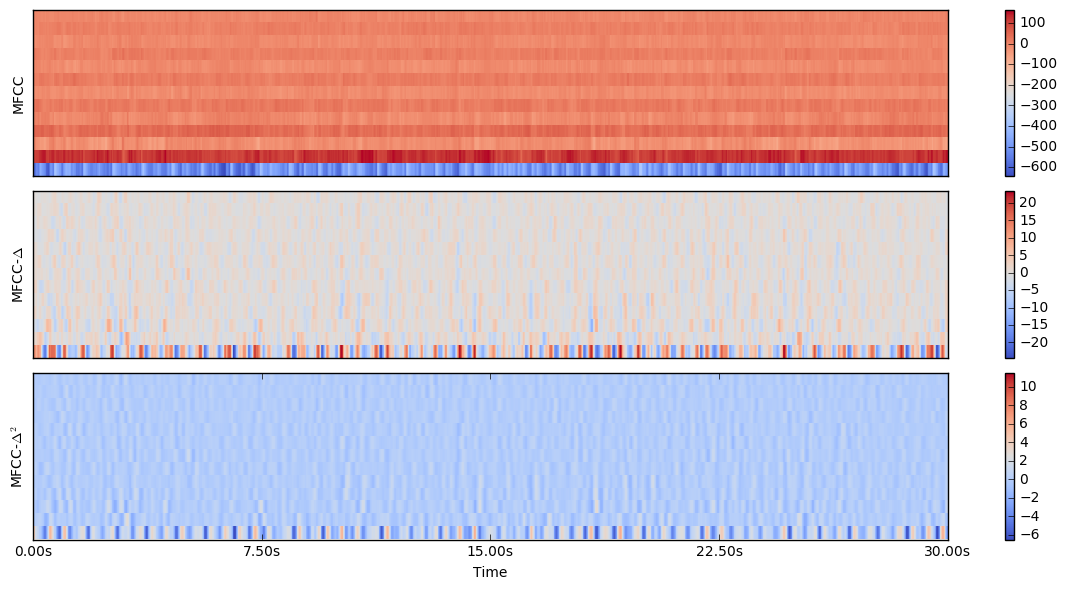

In [58]:
audio_path = "blues.00000.au"
y, sr = librosa.load(audio_path)
mfcc= librosa.feature.mfcc(S=log_S, n_mfcc=13)
delta_mfcc  = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 6))

plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()

plt.subplot(3,1,2)
librosa.display.specshow(delta_mfcc)
plt.ylabel('MFCC-$\Delta$')
plt.colorbar()

plt.subplot(3,1,3)
librosa.display.specshow(delta2_mfcc, sr=sr, x_axis='time')
plt.ylabel('MFCC-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

M = np.vstack([mfcc, delta_mfcc, delta2_mfcc])

In [61]:
np.shape(y)
root="../../data/genres/"

In [64]:
Y = os.listdir(root)

In [42]:
import glob
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz


def parse_audio_files(parent_dir,sub_dirs,file_ext='*.au'):
    features, labels = np.empty((0,193)), np.empty(0)
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            print(fn)
            mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
            
            ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
            features = np.vstack([features,ext_features])
            labels = np.append(labels, labels_dict[sub_dir])
            
            #with open(sub_dir+".pickle", 'wb') as f:
            #    pickle.dump((features,labels), f, pickle.HIGHEST_PROTOCOL)
            
    return np.array(features), np.array(labels,dtype = np.int)

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [43]:
labels_dict = {'blues':0,'classical':1,'country':2,'disco':3,'hiphop':4,'jazz':5,'metal':6,'pop':7,'reggae':8,'rock':9}
parent_dir = train_filename
tr_sub_dirs = labels_dict.keys()
tr_features, tr_labels = parse_audio_files(parent_dir,tr_sub_dirs)

E:\Applications\Github\GitHub\Machine-Learning-Engineer\p5 - Song Genre Classification\data\genres\reggae\reggae.00000.au
E:\Applications\Github\GitHub\Machine-Learning-Engineer\p5 - Song Genre Classification\data\genres\reggae\reggae.00001.au
E:\Applications\Github\GitHub\Machine-Learning-Engineer\p5 - Song Genre Classification\data\genres\reggae\reggae.00002.au
E:\Applications\Github\GitHub\Machine-Learning-Engineer\p5 - Song Genre Classification\data\genres\reggae\reggae.00003.au
E:\Applications\Github\GitHub\Machine-Learning-Engineer\p5 - Song Genre Classification\data\genres\reggae\reggae.00004.au
E:\Applications\Github\GitHub\Machine-Learning-Engineer\p5 - Song Genre Classification\data\genres\reggae\reggae.00005.au
E:\Applications\Github\GitHub\Machine-Learning-Engineer\p5 - Song Genre Classification\data\genres\reggae\reggae.00006.au
E:\Applications\Github\GitHub\Machine-Learning-Engineer\p5 - Song Genre Classification\data\genres\reggae\reggae.00007.au
E:\Applications\Github\G

In [44]:
with open("data_for_training.pickle", 'wb') as f:
    pickle.dump((tr_features,tr_labels), f, pickle.HIGHEST_PROTOCOL)

In [111]:
labels=tr_labels
n_labels = len(labels)
n_unique_labels = len(np.unique(labels))

In [39]:
otr_labels

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,

In [34]:
otr_labels = one_hot_encode(tr_labels)

In [36]:
training_epochs = 5000
n_dim = tr_features.shape[1]
n_classes = 10
n_hidden_units_one = 280 
n_hidden_units_two = 300
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.01

In [37]:
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.tanh(tf.matmul(X,W_1) + b_1)


W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)


W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)

init = tf.initialize_all_variables()

NameError: name 'tf' is not defined

In [ ]:
cost_function = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(y_), reduction_indices=[1])) 
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:tr_features,Y:tr_labels})
        cost_history = np.append(cost_history,cost)
    
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: ts_features})
    y_true = sess.run(tf.argmax(ts_labels,1))
    print('Test accuracy: ',round(session.run(accuracy, feed_dict={X: ts_features, Y: ts_labels}) , 3))

fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print "F-Score:", round(f,3)

# CNN

In [12]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += (window_size / 2)

def extract_features(parent_dir,sub_dirs,file_ext="*.wav",bands = 60, frames = 41):
    window_size = 512 * (frames - 1)
    log_specgrams = []
    labels = []
    for l, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            sound_clip,s = librosa.load(fn)
            label = fn.split('/')[2].split('-')[1]
            for (start,end) in windows(sound_clip,window_size):
                if(len(sound_clip[start:end]) == window_size):
                    signal = sound_clip[start:end]
                    melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
                    logspec = librosa.logamplitude(melspec)
                    logspec = logspec.T.flatten()[:, np.newaxis].T
                    log_specgrams.append(logspec)
                    labels.append(label)
            
    log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
    for i in range(len(features)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
    return np.array(features), np.array(labels,dtype = np.int)

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [24]:
labels_dict = {'blues':0,'classical':1}
parent_dir = train_filename
sub_dirs = labels_dict.keys()
features, labels = extract_features(parent_dir,sub_dirs)

In [25]:
np.shape(features)

(0L, 60L, 41L, 2L)

In [23]:
features

array([], shape=(0L, 60L, 41L, 2L), dtype=float64)

In [16]:
from sklearn import linear_model
from sklearn import pipeline
from sklearn import cross_validation

C:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
pipe = pipeline.Pipeline([
        ("logistic", linear_model.LogisticRegression())
    ])

In [18]:
train_dataset_flat = [np.ndarray.flatten(t) for t in features]

In [20]:
train_dataset_flat

[]

In [19]:
cross_validation.cross_val_score(
    pipe,
    train_dataset_flat[:50], labels[:50]
)

ValueError: Cannot have number of folds n_folds=3 greater than the number of samples: 0.